In [2]:
import warnings
warnings.filterwarnings('ignore')

from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun, ShellTool
from langchain_community.agent_toolkits.playwright.toolkit import PlayWrightBrowserToolkit
# from langchain_community.tools.playwright.utils import create_sync_playwright_browser 

from langchain_community.tools.playwright.utils import create_async_playwright_browser
import nest_asyncio
nest_asyncio.apply()

from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from typing_extensions import TypedDict, Annotated, Sequence, List, Literal, Optional, Dict
from typing import Any
import operator
from pprint import pprint
import json
import uuid
import os

# --- 1. Utils (Model, Tools) ---

In [3]:
def _get_model(model_name: str = "openai"):
    """
    Returns an LLM instance based on the specified model name.
    """
    if model_name == "openai":
        model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
    else:
        raise ValueError(f"Unsupported model type: {model_name}")
    return model

async_browser = create_async_playwright_browser()
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
playwright_tools = toolkit.get_tools()

# sync_browser = create_sync_playwright_browser()
# toolkit = PlayWrightBrowserToolkit.from_browser(sync_browser=sync_browser)
# playwright_tools = toolkit.get_tools()

tools = [
    DuckDuckGoSearchRun(
        name="duckduckgo_search",
        description="Performs internet searches. Use this to find current information or general knowledge."
    ),
    ShellTool(
        name="shell_tool",
        description="Executes Linux shell commands. Use this for system information, file manipulation, and running network utilities (e.g., ping, nmap). Commands must be provided as a list of strings."
    )
]
tools = tools + playwright_tools
tool_node = ToolNode(tools)

In [4]:
tools

[DuckDuckGoSearchRun(description='Performs internet searches. Use this to find current information or general knowledge.', api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text')),
 ShellTool(name='shell_tool', description='Executes Linux shell commands. Use this for system information, file manipulation, and running network utilities (e.g., ping, nmap). Commands must be provided as a list of strings.', process=<langchain_experimental.llm_bash.bash.BashProcess object at 0xffff8403c1a0>),
 ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/kali/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/kali/.cache/ms-playwright/chromium-1169/chrome-linux/chrome> version=136.0.7103.25>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium execu

# --- 2. State Definition ---

In [5]:
class PentestState(TypedDict):
    messages: Annotated[Sequence[AnyMessage], operator.add]
    initial_query: str # Store the initial user query to prevent re-processing
    current_step: Literal['supervisor', 'pentester', 'evaluator', 'recorder', '__end__']
    pentest_tasks: List[str]
    current_task: Optional[str]
    evaluation: Optional[Dict] # Store the entire evaluation response for clarity
    findings: Dict[str, List[str]]
    tool_input_message: Optional[AIMessage]
    tool_results: Optional[str]
    retry_count: int

# --- 3. System Prompts ---

In [6]:
PENTESTER_SYSTEM_PROMPT = """
You are a skilled Penetration Testing Expert AI. Your goal is to perform a thorough penetration test based on the given task and conversation history.
Available tools: {tool_names}.

You must respond in the following structured JSON format.
Based on the task and previous conversation history, determine the next steps.
If a tool needs to be used, set `tool_use` to `true` and provide the correct `tool_name` and `tool_args`.

- "thought": Your reasoning for the chosen action.
- "phase": The current penetration testing phase.
- "tool_use": A boolean indicating if a tool should be used.
- "tool_name": The name of the tool to use, if tool_use is true.
- "tool_args": A dictionary of arguments for the tool, matching the tool's expected input format. For example, `{{ "url": "https://example.com" }}` for Playwright Tools or `{{ "commands": ["nmap -F target.com"] }}` for `shell_tool`.
- "summary": A brief summary of your planned action.

<example_shell>
User: Perform a fast port scan on 10.10.11.18.
{{
  "thought": "I need to perform a fast port scan on target 10.10.11.18. I will use the 'nmap -F' command via the shell_tool.",
  "phase": "Scanning",
  "tool_use": true,
  "tool_name": "shell_tool",
  "tool_args": {{ "commands": ["nmap -F 10.10.11.18"] }},
  "summary": "Preparing for fast port scan using Nmap."
}}
</example_shell>

<example_playwright>
User: Visit Hacker News (https://news.ycombinator.com/) and find the top-3 articles.
{{
  "thought": "First, I need to navigate to the Hacker News website. I will use the `NavigateTool` for this.",
  "phase": "Reconnaissance",
  "tool_use": true,
  "tool_name": "NavigateTool",
  "tool_args": {{ "url": "https://news.ycombinator.com/" }},
  "summary": "Navigating to Hacker News to begin recon."
}}
</example_playwright>

<example_extract_text>
User: I am on the Hacker News homepage. Extract all visible text.
{{
  "thought": "I have already navigated to the page. Now I need to extract the text content. I will use the `ExtractTextTool` for this.",
  "phase": "Reconnaissance",
  "tool_use": true,
  "tool_name": "ExtractTextTool",
  "tool_args": {{}},
  "summary": "Extracting text from the current page."
}}
</example_extract_text>
"""

EVALUATOR_SYSTEM_PROMPT = """
You are an AI responsible for evaluating the validity and completeness of penetration test results.
You will evaluate the response from the pentester agent and determine if the given task is completed, or if additional work is required.

Your response must be in the following structured JSON format.
- "task_successful": Set to true ONLY if the single, specific task provided was completed successfully. This does not mean the overall objective is finished.
- "fail": Set to true if the task failed and further progress on this path is impossible.
- "findings": Store key information discovered during the task. This can include IP addresses, open ports, full command outputs, or identified vulnerabilities.
- "summary": Provide a concise summary of the evaluation.

**IMPORTANT FORMATTING RULE FOR 'findings'**:
- All values in the 'findings' dictionary MUST have the correct data type.
- An IP address, a domain name, or a block of text MUST be a **single string**, for example: `"target_ipv4": "45.33.32.156"`.
- If there are multiple items, like a list of intermediate IPs, it MUST be a **list of strings**, for example: `"intermediate_ips": ["192.168.1.1", "10.0.0.1"]`.

<example>
Input: Pentester result: Server: 192.168.219.1 ... Name: scanme.nmap.org Address: 45.33.32.156
{{
  "thought": "The pentester successfully navigated to the page. Now, the text needs to be extracted to identify the articles.",
  "summary": "Navigation successful. Next step should be text extraction.",
  "task_successful": true, // 현재 하위 태스크는 성공
  "is_final_step": false, // 전체 목표는 아직 완료되지 않음
  "next_action_suggestion": "Use ExtractTextTool to get the page content.",
  "fail": false,
  "findings": {{
    "navigation_status": "Success, on page https://news.ycombinator.com/"
  }}
}}
</example>
"""

SUPERVISOR_SYSTEM_PROMPT = """
"You are the supervisor of a penetration testing AI team. Your role is to orchestrate the workflow.
1.  On the first run, analyze the user's request and break it down into a granular, step-by-step task list for the Pentester. Each task should correspond to a single tool use or a single logical action.
2.  On subsequent runs, review the Evaluator's feedback to decide the next step.
    - If the task is ongoing, create the next task for the Pentester.
    - If the Evaluator reports the overall objective is complete (`done: true`), delegate to the Recorder.
    - If the Evaluator reports a critical failure (`fail: true`), terminate the process.

Your response must be in the following structured JSON format.
- "next_agent" must be 'pentester', 'recorder', or '__end__'.

<example_initial>
Input: New pentest request: "Visit Hacker News (https://news.ycombinator.com/), extract the text, and find the top 3 articles."
{{
  "thought": "This is a new request. I will break it down into three distinct steps: navigating to the URL, extracting the text, and then analyzing that text.",
  "tasks": [
      "Navigate to the URL https://news.ycombinator.com/",
      "Extract all visible text from the current page.",
      "Analyze the extracted text to identify and list the top-3 popular articles."
  ],
  "next_agent": "pentester"
}}
</example_initial>

<example_continue>
Input: Evaluator feedback: "Port scan complete. Open ports found: 80, 22."
{{
  "thought": "The port scan is done. The next logical step is to analyze the services on the open ports.",
  "tasks": ["Analyze services on open ports 80 and 22 for vulnerabilities."],
  "next_agent": "pentester"
}}
</example_continue>

<example_finish>
Input: Evaluator feedback: "All tasks are completed. Final report needs to be generated." (done: true)
{{
  "thought": "The evaluator confirmed all objectives are met. I will now instruct the recorder to generate the final report.",
  "tasks": [],
  "next_agent": "recorder"
}}
</example_finish>
"""

RECORDER_FINAL_PROMPT = """
You are a technical writer who creates concise but detailed summaries of tasks performed.
Based on the entire message history and the final aggregated findings provided below, generate a summary report in Markdown format.

The report MUST include the following sections in order:
- **Request:** What did the user ask for?
- **Process:** What high-level steps were involved?
- **Tools Used:** What specific tools were executed?
- **Key Findings:** What were the detailed results and information gathered? Use the provided 'Final Findings' JSON to populate this section. Present it in a readable format.
- **Conclusion:** What is the final summary or answer provided to the user?

The final output must be a JSON object containing the 'report' in Markdown.
The second return 'file_name' should be ending with `.md` while its name reflects what it has done concatenated by '_'

<history>
{history}
</history>

<final_findings>
{findings}
</final_findings>

<example>
{{
  "report": "# Task Summary Report\\n\\n- **Request:** Scan for open ports on 'scanme.nmap.org'.\\n- **Process:** Executed an nmap port scan against the target host.\\n- **Tools Used:** `nmap`\\n- **Key Findings:**\\n  - `target_ipv4`: `45.33.32.156`\\n  - `open_ports`: `[22, 80]`\\n  - `service_info`: `{{'22': 'ssh', '80': 'http'}}`\\n- **Conclusion:** Reported the list of open ports to the user based on the scan results.",
  "file_name": "verify_ip_and_check_route.md"
}}
</example>
"""

# --- 4. Nodes ---

In [7]:
class PentesterResponse(TypedDict):
    thought: str
    phase: str
    tool_use: bool
    tool_name: Optional[str]
    tool_args: Optional[Dict[str, Any]] 
    summary: str

def pentester(state: PentestState) -> PentestState:
    print("\n--- PENTESTER ---")
    messages = [
        SystemMessage(content=PENTESTER_SYSTEM_PROMPT.format(tool_names=[tool.name for tool in tools])),
        *[msg for msg in state['messages'] if not isinstance(msg, SystemMessage)],
        HumanMessage(content=f"Based on all previous steps, execute the following task: {state['current_task']}")
    ]

    model = _get_model().with_structured_output(PentesterResponse)
    response: PentesterResponse = model.invoke(messages)
    print(f"  [log] Thought: {response.get('thought', 'No thought provided.')}")

    # Set the base state in advance.
    ai_message = AIMessage(content=response.get('summary', ''))
    new_state = {
        'messages': [ai_message],
        'current_task': state['current_task']
    }

    # --- Start of enhanced logic ---

    # 1. Safely retrieve the LLM's response. Using .get() prevents KeyErrors.
    use_tool = response.get('tool_use', False)
    tool_name = response.get('tool_name')
    tool_args = response.get('tool_args') # Can be None for tools that take no arguments.

    # 2. Check if the intent to use a tool is clear and a tool name was actually provided.
    if use_tool and tool_name:
        # Ensure args is always a dict to handle tools that take no arguments.
        validated_args = tool_args if tool_args is not None else {}
        
        print(f"  [log] Action: Using tool '{tool_name}' with arguments: {validated_args}")

        # Construct the message for the ToolNode.
        tool_calls = [{
            "id": str(uuid.uuid4()),
            "name": tool_name,
            "args": validated_args
        }]
        
        tool_input_message = AIMessage(content=response.get('summary', ''), tool_calls=tool_calls)
        new_state.update({
            'messages': [tool_input_message],
            'tool_input_message': tool_input_message,
        })
    else:
        # 3. Handle cases where no tool is used, or the LLM response is incomplete.
        if use_tool:
            # This case handles when use_tool is True but tool_name is missing.
            print(f"  [log] Warning: LLM indicated tool use but did not provide a tool name. Passing to evaluator without tool.")
        
        # Pass the summary in 'tool_results' to the evaluator.
        new_state['tool_results'] = response.get('summary', 'No tool action taken.')

    # --- End of enhanced logic ---
    
    return new_state

In [8]:
# def tools_node(state: PentestState) -> PentestState:
#     """
#     Executes the tool requested by the pentester.
#     The input to the prebuilt ToolNode is a list of messages.
#     """
#     print("\n--- TOOLS ---")
#     tool_input_message = state.get('tool_input_message')
#     if not tool_input_message or not tool_input_message.tool_calls:
#         # This should not happen if routed correctly, but as a safeguard:
#         return {'tool_results': "Error: Tool node was called without a tool to execute."}

#     print(f"  [log] Executing tool: {tool_input_message.tool_calls[0]['name']}")
    
#     # *** FIX: Pass the message as a list to tool_node.invoke ***
#     tool_result_messages = tool_node.invoke([tool_input_message])
    
#     # The result from ToolNode is a list of ToolMessage, we take the content of the first one.
#     tool_results = tool_result_messages[0].content
#     print(f"  [log] Tool output received.")

#     return {
#         'messages': [tool_result_messages[0]], # Add tool output to history
#         'tool_results': tool_results,
#         'tool_input_message': None # Clear after use
#     }

In [9]:
async def tools_node(state: PentestState) -> PentestState:
    """
    Executes the tool requested by the pentester.
    The input to the prebuilt ToolNode is a list of messages.
    """
    print("\n--- TOOLS ---")
    tool_input_message = state.get('tool_input_message')
    if not tool_input_message or not tool_input_message.tool_calls:
        # This should not happen if routed correctly, but as a safeguard:
        return {'tool_results': "Error: Tool node was called without a tool to execute."}

    print(f"  [log] Executing tool: {tool_input_message.tool_calls[0]['name']}")

    # *** FIX: Async call to tool_node ***
    tool_result_messages = await tool_node.ainvoke([tool_input_message])

    # The result from ToolNode is a list of ToolMessage, we take the content of the first one.
    tool_results = tool_result_messages[0].content
    print(f"  [log] Tool output received.")

    return {
        'messages': [tool_result_messages[0]],  # Add tool output to history
        'tool_results': tool_results,
        'tool_input_message': None  # Clear after use
    }


In [10]:
class EvalResponse(TypedDict):
    thought: str
    summary: str
    task_successful: bool 
    fail: bool
    findings: Dict[str, Any]

def evaluator(state: PentestState) -> PentestState:
    print("\n--- EVALUATOR ---")
    messages = [
        SystemMessage(content=EVALUATOR_SYSTEM_PROMPT),
        HumanMessage(content=f"Task: {state.get('current_task')}\n\nExecution Result:\n{state.get('tool_results', 'No tool output.')}")
    ]
    
    model = _get_model().with_structured_output(EvalResponse)
    response: EvalResponse = model.invoke(messages)
    print(f"  [log] Thought: {response['thought']}")
    print(f"  [log] Evaluation: {response['summary']}")

    # Merge findings
    updated_findings = state.get('findings', {}).copy()
    new_findings_from_llm = response.get('findings', {})

    if new_findings_from_llm:
        updated_findings.update(new_findings_from_llm)

    return {
        'messages': [AIMessage(content=f"Evaluation: {response['summary']}")],
        'evaluation': response,
        'findings': updated_findings,
        'tool_results': None # Clear after evaluation
    }

In [11]:
class SupervisorResponse(TypedDict):
    thought: str
    tasks: List[str]
    next_agent: Literal['pentester', 'recorder', '__end__']

def supervisor(state: PentestState) -> PentestState:
    print("\n--- SUPERVISOR ---")
    evaluation_feedback = state.get('evaluation')
    current_tasks = state.get('pentest_tasks', [])

    # This is the first run, triggered by the initial user query
    if not evaluation_feedback:
        print("  [log] Received initial request. Creating first task list.")
        prompt_messages = [
            SystemMessage(content=SUPERVISOR_SYSTEM_PROMPT),
            HumanMessage(content=f"New pentest request: \"{state['initial_query']}\"")
        ]
        model = _get_model().with_structured_output(SupervisorResponse)
        response: SupervisorResponse = model.invoke(prompt_messages)
        
        print(f"  [log] Thought: {response['thought']}")
        print(f"  [log] Next agent: '{response['next_agent']}', New tasks: {response['tasks']}")

        return {
            'messages': [AIMessage(content=f"Supervisor decision: Next up is {response['next_agent']}. Tasks: {response['tasks']}")],
            'pentest_tasks': response.get('tasks', []),
            'current_task': response.get('tasks', [None])[0],
            'current_step': response.get('next_agent', '__end__'),
            'evaluation': None
        }
    
    # After getting a feedback from evaluator
    print("  [log] Received feedback from Evaluator. Deciding next step.")
    
    if evaluation_feedback.get('fail'):
        print("  [log] Evaluator reported a failure. Terminating workflow.")
        return {'current_step': '__end__'}

    # Check if the task is successfully done
    if evaluation_feedback.get('task_successful'):
        print(f"  [log] Task '{state['current_task']}' completed successfully.")
        
        # Eliminate the completed task
        if current_tasks and current_tasks[0] == state['current_task']:
            remaining_tasks = current_tasks[1:]
        else:
            remaining_tasks = []
        
        # Check if any task remains
        if remaining_tasks:
            next_task = remaining_tasks[0]
            print(f"  [log] Continuing to next task: '{next_task}'")
            return {
                'messages': [AIMessage(content=f"Supervisor: Task successful. Next up: {next_task}")],
                'pentest_tasks': remaining_tasks,
                'current_task': next_task,
                'current_step': 'pentester',
                'evaluation': None # Initialize previous evaluation
            }
        else:
            # If all done, routing to Recorder
            print("  [log] All tasks are complete. Routing to Recorder.")
            return {
                'messages': [AIMessage(content="Supervisor: All tasks complete. Generating report.")],
                'current_step': 'recorder',
                'evaluation': None
            }
    
    # Task was not successful, but not a hard failure. Re-issue the task to the pentester.
    else:
        print(f"  [log] Task not fully successful. Re-issuing task to pentester: '{state['current_task']}'")
        return {
            'messages': [AIMessage(content=f"Supervisor: The previous action did not fully complete the task. Please try again or take the next logical step for the current task: {state['current_task']}")] ,
            'current_step': 'pentester',
            'evaluation': None
        }

In [12]:
class ReportResponse(TypedDict):
    report: str
    file_name: str

def recorder(state: PentestState) -> PentestState:
    print("\n--- RECORDER ---")
    print("  [log] Generating final report...")

    # Jsonize to send finds to prompt
    final_findings = json.dumps(state.get('findings', {}), indent=2)

    history_str = ""
    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            history_str += f"Human: {msg.content}\n\n"
        elif isinstance(msg, AIMessage):
            history_str += f"AI: {msg.content}\n\n"
        elif isinstance(msg, ToolMessage):
            history_str += f"Tool Output: {msg.content}\n\n"

    # Send findings with prompt history
    prompt = RECORDER_FINAL_PROMPT.format(history=history_str, findings=final_findings)
    model = _get_model().with_structured_output(ReportResponse)
    response: ReportResponse = model.invoke(prompt)

    # File save
    file_name = response['file_name']
    report_content = response['report']

    os.makedirs("reports", exist_ok=True)
    file_path = os.path.join("reports", file_name)

    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(report_content)
    print(f"  [log] Final report saved to '{file_path}'")

    return {
        'messages': [AIMessage(content=f"Final report generated and saved to {file_path}. Final findings: {final_findings}")],
        'current_step': '__end__'
    }

# --- 5. Routing Logic ---

In [13]:
def route_from_supervisor(state: PentestState) -> Literal['pentester', 'recorder', '__end__']:
    return state['current_step']

def route_from_pentester(state: PentestState) -> Literal['tools_node', 'evaluator']:
    if state.get('tool_input_message'):
        return 'tools_node'
    return 'evaluator'

# --- 6. Graph Definition ---

In [14]:
workflow = StateGraph(PentestState)

workflow.add_node('supervisor', supervisor)
workflow.add_node('pentester', pentester)
workflow.add_node('tools_node', tools_node)
workflow.add_node('evaluator', evaluator)
workflow.add_node('recorder', recorder)

workflow.set_entry_point('supervisor')

workflow.add_conditional_edges('supervisor', route_from_supervisor, {
    'pentester': 'pentester',
    'recorder': 'recorder',
    '__end__': END
})

workflow.add_conditional_edges('pentester', route_from_pentester, {
    'tools_node': 'tools_node',
    'evaluator': 'evaluator'
})

workflow.add_edge('tools_node', 'evaluator')
workflow.add_edge('evaluator', 'supervisor')
# The recorder's job is the last one, so it leads to the end.
workflow.add_edge('recorder', END)

pentest_graph = workflow.compile()


--- Langgraph Graph Visualization ---


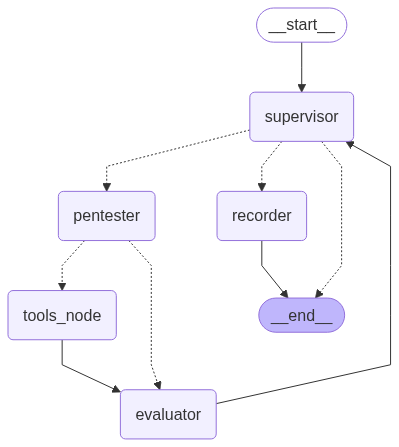

In [15]:
print("\n--- Langgraph Graph Visualization ---")
try:
    from IPython.display import display, Image
    display(Image(pentest_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error during graph visualization: {e}")

# --- 7. Execution ---

In [19]:
# Test queries
# query = "Check what's intermediate IPs until scanme.nmap.org's IP. First, you need to check its IP using nslookup. Then you can use traceroute."
# query = "Perform a fast port scan on scanme.nmap.org to identify open TCP ports."
# query = "Visit Hacker News (https://news.ycombinator.com/). Then extract texts from the page and answer how much money Meta invested on superintelligence lab"
# query = "Visit website 'Books to Scrape' (books.toscrape.com), and then tell me the price of the first book on 'Science' category."
# query = "Move to the website 'https://www.iana.org/help/example-domains'. Then list up all href links in the page recursively. You can recursive down at most 2 steps."
# query = "Visit http://192.168.123.107:3000 and tell me what this site is."
query = "Visit http://192.168.123.107:3000 and sign-up with a test account. Let me know what user credential you used."


initial_state = {
    "messages": [], # Start with an empty message list
    "initial_query": query, # Store the query separately
    "findings": {},
    "retry_count": 0
}

print(f"\n--- Starting Pentest For: {query} ---\n")

# To avoid printing redundant state messages, we'll track the number of messages
num_messages_printed = 0

# for chunk in pentest_graph.stream(initial_state, stream_mode="values"):
async for chunk in pentest_graph.astream(initial_state, stream_mode="values"):
    # The 'messages' in the state are updated by operator.add, so we can
    # check for new messages by comparing lengths.
    current_messages = chunk.get('messages', [])
    if len(current_messages) > num_messages_printed:
        new_messages = current_messages[num_messages_printed:]
        for msg in new_messages:
            # This logic can be refined, but it's a simple way to see the flow
            if isinstance(msg, AIMessage):
                if msg.tool_calls:
                     print(f"  [AI Action] Requesting tool: {msg.tool_calls[0]['name']} with args {msg.tool_calls[0]['args']}")
                else:
                    print(f"  [AI Message] {msg.content}")
            elif isinstance(msg, ToolMessage):
                # Only print a summary of tool results to keep the log clean
                print(f"  [Tool Result] {msg.content[:300]}...")
        num_messages_printed = len(current_messages)

print("\n--- Pentest Workflow Complete ---")
final_state = chunk
pprint(f"\nFinal Findings: {final_state.get('findings')}")


--- Starting Pentest For: Visit http://192.168.123.107:3000 and sign-up with a test account. Let me know what user credential you used. ---


--- SUPERVISOR ---
  [log] Received initial request. Creating first task list.
  [log] Thought: This is a new request. I will break it down into distinct steps: navigating to the URL, signing up with a test account, and reporting the user credentials used.
  [log] Next agent: 'pentester', New tasks: ['Navigate to the URL http://192.168.123.107:3000', 'Locate the sign-up form on the page.', 'Fill in the sign-up form with test account details (e.g., username: testuser, password: testpass).', 'Submit the sign-up form.', 'Record the user credentials used for the sign-up.']
  [AI Message] Supervisor decision: Next up is pentester. Tasks: ['Navigate to the URL http://192.168.123.107:3000', 'Locate the sign-up form on the page.', 'Fill in the sign-up form with test account details (e.g., username: testuser, password: testpass).', 'Submit the sign-up fo